Solution was successful!


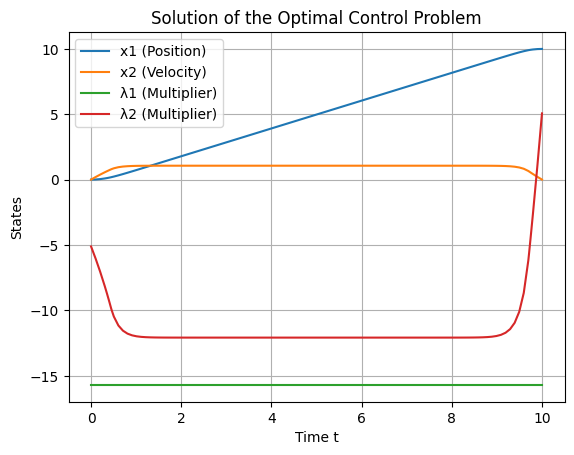

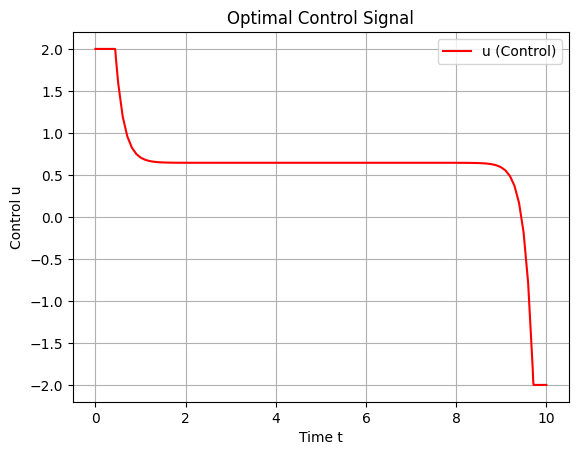

In [8]:
import numpy as np
from scipy.integrate import solve_bvp
import matplotlib.pyplot as plt

# Constants
k1 = 0.5
k2 = 0.1
k3 = 1
k4 = 10
c1 = c2 = 1000
xf = 10
R = 0.3
u_min = -2
u_max = 2
T = 10

# System state equations
# System state equations
def system(t, y, p=None):  # Add p as an optional argument
    x1, x2, lambda1, lambda2 = y
    # Optimal control law with bounds
    u = -np.clip((lambda2 * k3 + (k3 + k4) * x2) / (2 * R), u_min, u_max)
    # State derivatives
    dx1_dt = x2
    dx2_dt = -k1 * x2 - k2 * x2**2 + k3 * u
    # Adjoint equations (Lagrange multipliers)
    dlambda1_dt = np.zeros_like(t)  # Ensure it has the same shape as t
    dlambda2_dt = -lambda1 + lambda2 * (k1 + 2 * k2 * x2) - k3 * u - k4 * u
    return np.vstack([dx1_dt, dx2_dt, dlambda1_dt, dlambda2_dt])


# Boundary conditions
def boundary_conditions(ya, yb):
    x1a, x2a, lambda1a, lambda2a = ya
    x1b, x2b, lambda1b, lambda2b = yb
    return np.array([
        x1a,                     # x1(0) = 0 (initial position)
        x2a,                     # x2(0) = 0 (initial velocity)
        lambda1b - 2 * c1 * (x1b - xf),  # λ1(T) = 2 * c1 * (x1(T) - xf)
        lambda2b - 2 * c2 * x2b          # λ2(T) = 2 * c2 * x2(T)
    ])

# Initial guess for the solution
t = np.linspace(0, T, 100)
y_guess = np.zeros((4, t.size))

# Solve the boundary value problem
solution = solve_bvp(system, boundary_conditions, t, y_guess)

# Check if the solution was successful
if solution.success:
    print("Solution was successful!")
else:
    print("Solution did not converge.")

# Plot the results
plt.plot(solution.x, solution.y[0], label='x1 (Position)')
plt.plot(solution.x, solution.y[1], label='x2 (Velocity)')
plt.plot(solution.x, solution.y[2], label='λ1 (Multiplier)')
plt.plot(solution.x, solution.y[3], label='λ2 (Multiplier)')
plt.xlabel('Time t')
plt.ylabel('States')
plt.legend()
plt.title('Solution of the Optimal Control Problem')
plt.grid()
plt.show()

# Calculate the optimal control signal
u_optimal = -np.clip((solution.y[3] * k3 + (k3 + k4) * solution.y[1]) / (2 * R), u_min, u_max)

# Plot the control signal
plt.plot(solution.x, u_optimal, label='u (Control)', color='red')
plt.xlabel('Time t')
plt.ylabel('Control u')
plt.legend()
plt.title('Optimal Control Signal')
plt.grid()
plt.show()


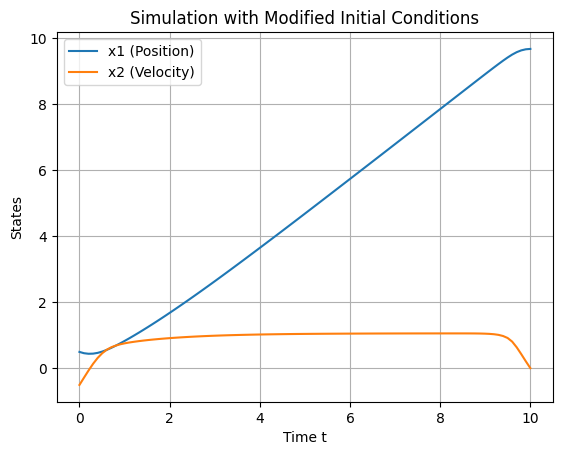

In [9]:
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Define new initial conditions
x1_initial = 0.5  # Slightly different from the previous x1(0) = 0
x2_initial = -0.5  # Slightly different from the previous x2(0) = 0

# Define the system dynamics with the control signal from the previous solution
def simulate_system(t, y):
    x1, x2 = y
    # Use the control signal from the previous solution
    u = -np.clip((interp_lambda2(t) * k3 + (k3 + k4) * interp_x2(t)) / (2 * R), u_min, u_max)
    dx1_dt = x2
    dx2_dt = -k1 * x2 - k2 * x2**2 + k3 * u
    return [dx1_dt, dx2_dt]

# Interpolate previous solution for x2 and λ2
from scipy.interpolate import interp1d
interp_x2 = interp1d(solution.x, solution.y[1], fill_value="extrapolate")
interp_lambda2 = interp1d(solution.x, solution.y[3], fill_value="extrapolate")

# Solve the system dynamics with new initial conditions
t_span = (0, T)
y0 = [x1_initial, x2_initial]
t_eval = np.linspace(0, T, 100)
solution_sim = solve_ivp(simulate_system, t_span, y0, t_eval=t_eval)

# Plot the results
plt.figure()
plt.plot(solution_sim.t, solution_sim.y[0], label='x1 (Position)')
plt.plot(solution_sim.t, solution_sim.y[1], label='x2 (Velocity)')
plt.xlabel('Time t')
plt.ylabel('States')
plt.legend()
plt.title('Simulation with Modified Initial Conditions')
plt.grid()
plt.show()


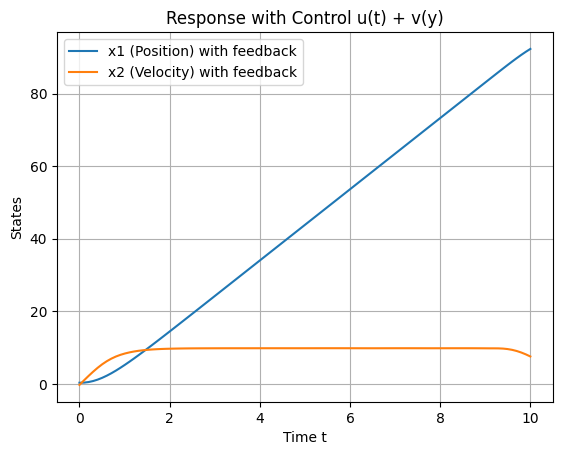

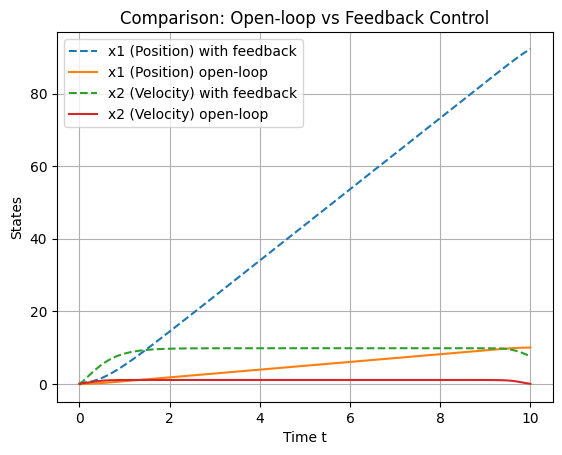

In [11]:
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import numpy as np

# Interpolate the previously computed results for x2, lambda1, and lambda2
interp_x2 = interp1d(solution.x, solution.y[1], fill_value="extrapolate")
interp_lambda2 = interp1d(solution.x, solution.y[3], fill_value="extrapolate")
interp_lambda1 = interp1d(solution.x, solution.y[2], fill_value="extrapolate")  # Fixed

# Define constants for B(t), assuming simple linearized system matrices
B1, B2 = 1, 1  # Adjust these values as needed

# Define system dynamics with control input u(t) + v(y)
def controlled_system(t, x):
    x1, x2 = x
    # Optimal open-loop control u(t)
    u_t = -np.clip((interp_lambda2(t) * k3 + (k3 + k4) * interp_x2(t)) / (2 * R), u_min, u_max)
    # Feedback correction v(y)
    v_y = -0.5 * (interp_lambda1(t) * B1 + interp_lambda2(t) * B2)
    # Combined control
    u = u_t + v_y
    # System dynamics
    dx1_dt = x2
    dx2_dt = -k1 * x2 - k2 * x2**2 + k3 * u
    return [dx1_dt, dx2_dt]

# Define initial conditions slightly different from the nominal ones
initial_conditions = [0.3, -0.3]

# Solve the system dynamics
t_span = (0, T)
t_eval = np.linspace(0, T, 100)
solution_feedback = solve_ivp(controlled_system, t_span, initial_conditions, t_eval=t_eval)

# Plot the results
plt.figure()
plt.plot(solution_feedback.t, solution_feedback.y[0], label="x1 (Position) with feedback")
plt.plot(solution_feedback.t, solution_feedback.y[1], label="x2 (Velocity) with feedback")
plt.xlabel("Time t")
plt.ylabel("States")
plt.legend()
plt.title("Response with Control u(t) + v(y)")
plt.grid()
plt.show()

# Comparison with open-loop control u(t)
plt.figure()
plt.plot(solution_feedback.t, solution_feedback.y[0], label="x1 (Position) with feedback", linestyle="dashed")
plt.plot(solution.x, solution.y[0], label="x1 (Position) open-loop")
plt.plot(solution_feedback.t, solution_feedback.y[1], label="x2 (Velocity) with feedback", linestyle="dashed")
plt.plot(solution.x, solution.y[1], label="x2 (Velocity) open-loop")
plt.xlabel("Time t")
plt.ylabel("States")
plt.legend()
plt.title("Comparison: Open-loop vs Feedback Control")
plt.grid()
plt.show()


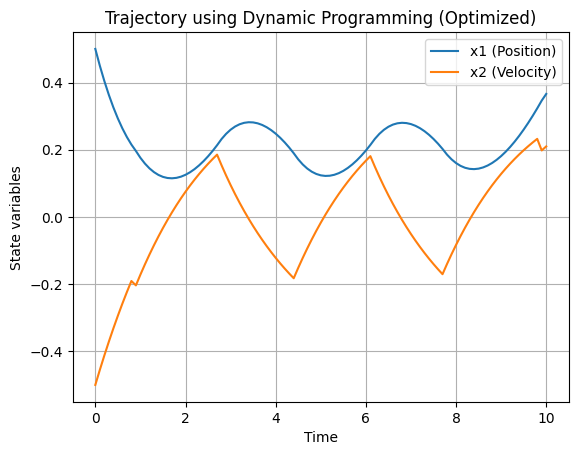

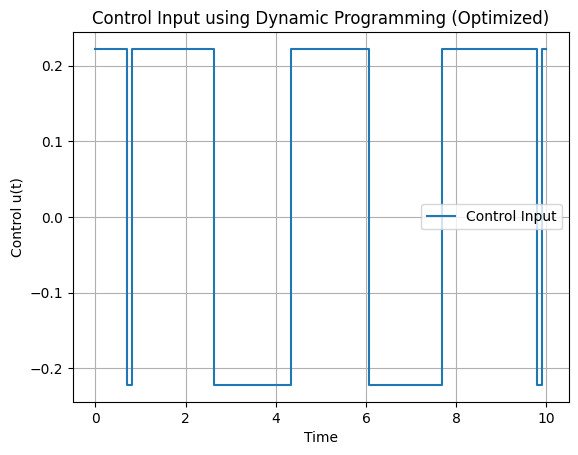

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
T = 10          # Total time
N = 100         # Reduced number of time steps
dt = T / N      # Time step size
u_min, u_max = -2, 2
x1_max, x2_max = 10, 10
grid_points = 50  # Reduced state space grid points

# State grid
x1 = np.linspace(-x1_max, x1_max, grid_points)
x2 = np.linspace(-x2_max, x2_max, grid_points)
X1, X2 = np.meshgrid(x1, x2)

# Initialize value function and policy
V = np.zeros((grid_points, grid_points, N + 1))
policy = np.zeros((grid_points, grid_points, N))

# Terminal cost
for i in range(grid_points):
    for j in range(grid_points):
        V[i, j, -1] = 20 * (X1[i, j] - 10)**2 + 20 * X2[i, j]**2

# Backward iteration for dynamic programming
for k in range(N - 1, -1, -1):
    for i in range(grid_points):
        for j in range(grid_points):
            x1_current, x2_current = X1[i, j], X2[i, j]
            costs = []
            controls = []
            for u in np.linspace(u_min, u_max, 10):  # Reduced control discretization
                # State update
                x1_next = x1_current + x2_current * dt
                x2_next = x2_current + (-0.5 * x2_current - 0.1 * x2_current**2 + u) * dt

                # Ensure states are within bounds
                if abs(x1_next) <= x1_max and abs(x2_next) <= x2_max:
                    i_next = int((x1_next + x1_max) / (2 * x1_max) * (grid_points - 1))
                    j_next = int((x2_next + x2_max) / (2 * x2_max) * (grid_points - 1))
                    cost = 2 * x1_current**2 + 2 * x2_current**2 + u**2 + V[i_next, j_next, k + 1]
                    costs.append(cost)
                    controls.append(u)

            if costs:
                V[i, j, k] = min(costs)
                policy[i, j, k] = controls[np.argmin(costs)]

# Simulation with new initial conditions
x1_init, x2_init = 0.5, -0.5
trajectory_x1 = [x1_init]
trajectory_x2 = [x2_init]
control_inputs = []

for k in range(N):
    i = int((trajectory_x1[-1] + x1_max) / (2 * x1_max) * (grid_points - 1))
    j = int((trajectory_x2[-1] + x2_max) / (2 * x2_max) * (grid_points - 1))
    u = policy[i, j, k]
    control_inputs.append(u)
    x1_next = trajectory_x1[-1] + trajectory_x2[-1] * dt
    x2_next = trajectory_x2[-1] + (-0.5 * trajectory_x2[-1] - 0.1 * trajectory_x2[-1]**2 + u) * dt
    trajectory_x1.append(x1_next)
    trajectory_x2.append(x2_next)

# Plot results
plt.figure()
plt.plot(np.linspace(0, T, N + 1), trajectory_x1, label="x1 (Position)")
plt.plot(np.linspace(0, T, N + 1), trajectory_x2, label="x2 (Velocity)")
plt.xlabel("Time")
plt.ylabel("State variables")
plt.legend()
plt.title("Trajectory using Dynamic Programming (Optimized)")
plt.grid()
plt.show()

plt.figure()
plt.step(np.linspace(0, T, N), control_inputs, label="Control Input")
plt.xlabel("Time")
plt.ylabel("Control u(t)")
plt.legend()
plt.title("Control Input using Dynamic Programming (Optimized)")
plt.grid()
plt.show()


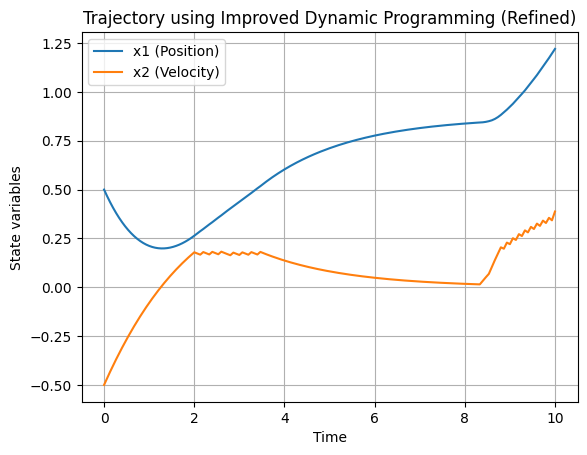

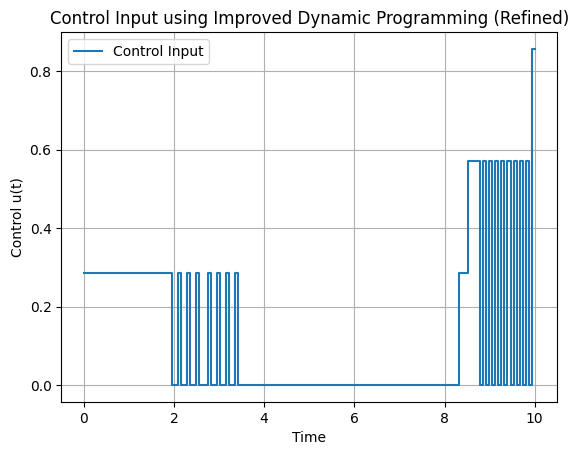

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
T = 10          # Total time
N = 150         # Moderate time steps for performance and accuracy
dt = T / N      # Time step size
u_min, u_max = -2, 2
x1_max, x2_max = 10, 10
grid_points = 60  # Moderate grid size for states

# State grid
x1 = np.linspace(-x1_max, x1_max, grid_points)
x2 = np.linspace(-x2_max, x2_max, grid_points)
X1, X2 = np.meshgrid(x1, x2)

# Initialize value function and policy
V = np.zeros((grid_points, grid_points, N + 1))
policy = np.zeros((grid_points, grid_points, N))

# Terminal cost
for i in range(grid_points):
    for j in range(grid_points):
        V[i, j, -1] = 20 * (X1[i, j] - 10)**2 + 20 * X2[i, j]**2

# Backward iteration for dynamic programming
for k in range(N - 1, -1, -1):
    for i in range(grid_points):
        for j in range(grid_points):
            x1_current, x2_current = X1[i, j], X2[i, j]
            costs = []
            controls = []
            for u in np.linspace(u_min, u_max, 15):  # Increased control sampling
                # State update
                x1_next = x1_current + x2_current * dt
                x2_next = x2_current + (-0.5 * x2_current - 0.1 * x2_current**2 + u) * dt

                # Ensure states are within bounds
                if abs(x1_next) <= x1_max and abs(x2_next) <= x2_max:
                    i_next = int((x1_next + x1_max) / (2 * x1_max) * (grid_points - 1))
                    j_next = int((x2_next + x2_max) / (2 * x2_max) * (grid_points - 1))
                    penalty = 0 if len(controls) == 0 else (u - controls[-1])**2
                    cost = 2 * x1_current**2 + 2 * x2_current**2 + u**2 + 0.2 * penalty + V[i_next, j_next, k + 1]
                    costs.append(cost)
                    controls.append(u)

            if costs:
                V[i, j, k] = min(costs)
                policy[i, j, k] = controls[np.argmin(costs)]

# Simulation with new initial conditions
x1_init, x2_init = 0.5, -0.5
trajectory_x1 = [x1_init]
trajectory_x2 = [x2_init]
control_inputs = []

for k in range(N):
    i = int((trajectory_x1[-1] + x1_max) / (2 * x1_max) * (grid_points - 1))
    j = int((trajectory_x2[-1] + x2_max) / (2 * x2_max) * (grid_points - 1))
    u = policy[i, j, k]
    control_inputs.append(u)
    x1_next = trajectory_x1[-1] + trajectory_x2[-1] * dt
    x2_next = trajectory_x2[-1] + (-0.5 * trajectory_x2[-1] - 0.1 * trajectory_x2[-1]**2 + u) * dt
    trajectory_x1.append(x1_next)
    trajectory_x2.append(x2_next)

# Plot results
plt.figure()
plt.plot(np.linspace(0, T, N + 1), trajectory_x1, label="x1 (Position)")
plt.plot(np.linspace(0, T, N + 1), trajectory_x2, label="x2 (Velocity)")
plt.xlabel("Time")
plt.ylabel("State variables")
plt.legend()
plt.title("Trajectory using Improved Dynamic Programming (Refined)")
plt.grid()
plt.show()

plt.figure()
plt.step(np.linspace(0, T, N), control_inputs, label="Control Input")
plt.xlabel("Time")
plt.ylabel("Control u(t)")
plt.legend()
plt.title("Control Input using Improved Dynamic Programming (Refined)")
plt.grid()
plt.show()
